In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#connect
conn = engine.connect()
#look at the whole tables
m = pd.read_sql("SELECT * FROM measurement", conn)
s = pd.read_sql("SELECT * FROM station", conn) 
m['date'].max()

'2017-08-23'

In [12]:
m['prcp'].max()

11.53

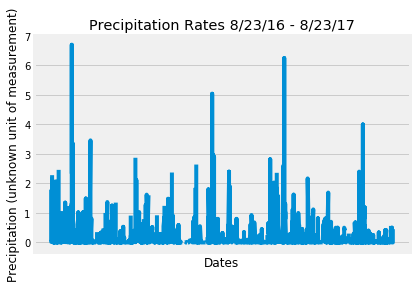

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# last point is 8/23/17, one year ago is 8/23/16

# Perform a query to retrieve the data and precipitation scores
last_year = pd.read_sql("SELECT * FROM measurement WHERE date >= '2016-08-23'", conn)

# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_df = pd.DataFrame(last_year)

last_year_df = last_year_df.set_index('date')


# Sort the dataframe by date

last_year_df = last_year_df.sort_values('date', ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(last_year_df["prcp"])

plt.xlabel("Dates")
plt.ylabel("Precipitation (unknown unit of measurement)")

plt.xticks([])

plt.title("Precipitation Rates 8/23/16 - 8/23/17")

plt.savefig("Outputs/precipitation_year.png")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [14]:
# Design a query to show how many stations are available in this dataset?

# This works: m['station'].unique() but here is a query:

unique_stations = pd.read_sql("SELECT DISTINCT station FROM measurement", conn)

unique_stations


,station
0,USC00519397
1,USC00513117
2,USC00514830
3,USC00517948
4,USC00518838
5,USC00519523
6,USC00519281
7,USC00511918
8,USC00516128


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#In Pandas do this:
#activity = m.groupby(['station']).count()
#activity = activity['id'].sort_values(ascending = False)
#activity

#query:
active_stations = pd.read_sql("SELECT SUM(station LIKE 'USC00519397') AS USC00519397, \
SUM(station LIKE 'USC00513117') AS USC00513117, \
SUM(station LIKE 'USC00514830') AS USC00514830, \
SUM(station LIKE 'USC00517948') AS USC00517948, \
SUM(station LIKE 'USC00518838') AS USC00518838, \
SUM(station LIKE 'USC00519523') AS USC00519523, \
SUM(station LIKE 'USC00519281') AS USC00519281, \
SUM(station LIKE 'USC00511918') AS USC00511918, \
SUM(station LIKE 'USC00516128') AS USC00516128 FROM measurement", conn)


active_stations = active_stations.transpose()
active_stations = active_stations.rename(columns={0:"Number of Entries"})

active_stations = active_stations.sort_values(by=["Number of Entries"],ascending = False)
active_stations

,Number of Entries
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


top_station = pd.read_sql("SELECT MAX(tobs) AS 'Max. Temp.', MIN(tobs) AS 'Min. Temp.', AVG(tobs) AS 'Avg. Temp.' \
FROM measurement \
WHERE station = 'USC00519281'", conn)

top_station

,Max. Temp.,Min. Temp.,Avg. Temp.
0,85.0,54.0,71.663781


In [19]:
m["date"].max()

'2017-08-23'

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_last_year = pd.read_sql("SELECT * FROM measurement \
WHERE date >= '2016-08-23' \
AND station = 'USC00519281'", conn)

station_last_year = station_last_year.sort_values('date', ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data

plt.hist(station_last_year["tobs"])

plt.xlabel("Dates")
plt.locator_params(axis='x', nbins=12)

plt.ylabel("Temperature (Assuming Fahrenheit)")

plt.title("Temperature at Station USC00519281")

plt.savefig("Outputs/station_precipitation_year.png")

station_last_year

NameError: name 'pd' is not defined

In [129]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [130]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

result = calc_temps('2017-03-06', '2017-03-12')
result[0][2] - result[0][0]

20.0

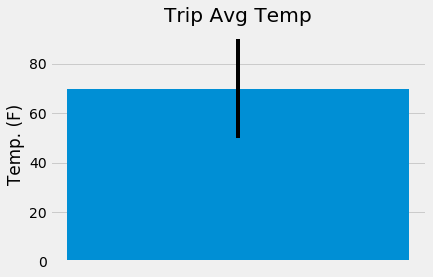

In [131]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(1, round(result[0][1]), yerr=result[0][2]-result[0][0])

plt.title("Trip Avg Temp")

plt.xticks([])

plt.ylabel("Temp. (F)")

plt.savefig("Outputs/trip_avg_temp.png")


In [132]:
m.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [133]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_weather = pd.read_sql("SELECT SUM(measurement.prcp) AS 'total prcp', station.station, station.name, \
station.latitude, station.longitude, station.elevation \
FROM measurement, station  \
WHERE measurement.date >= '2017-03-06' \
AND measurement.date <= '2017-03-12' \
AND station.station = measurement.station \
GROUP BY station.station \
ORDER BY SUM(measurement.prcp) DESC", conn)

trip_weather

,total prcp,station,name,latitude,longitude,elevation
0,1.47,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,0.72,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.63,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,0.01,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,0.00,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.00,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
